In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa.display
import librosa, keras, math, os, sys, os, random
import tensorflow as tf
import cv2 as cv
from keras import layers, utils
from keras.datasets import fashion_mnist, cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from random import sample, random, randint

In [2]:
def get_data():
    laudio_mono = []
    for i in os.listdir("data"):
        if "." in i: break
        for wav in os.listdir(f"data/{i}"):
            if ".wav" in wav:
                samples, sr = librosa.load(f"data/{i}/{wav}")
                laudio_mono.append((librosa.to_mono(samples), sr, wav.split(".")[0]))

    return laudio_mono
        
def resample(sample_mono, sample_rate, sr): 
    return librosa.resample(sample_mono, orig_sr=sample_rate, target_sr=sr)

def add_shift(shift_limit, sample_resamp, sample_trunc):
    # Si queremos añadir desplazamientos
    sig_len = sample_resamp.shape[0]
    shift_len = int(shift_limit * sig_len)
    return np.roll(sample_trunc, shift_len)

def add_noise(sample_shift, srn):
    RMS_s = math.sqrt(np.mean(sample_shift**2)) 
    RMS_n = math.sqrt(RMS_s**2/(pow(10, srn/10))) 
    noise = np.random.normal(0, RMS_n, sample_shift.shape[0]) 
    return sample_shift + noise        

def spectogram(sample_noise, n_fft, hop_length=None):
    sgram = librosa.stft(sample_noise, n_fft=n_fft, hop_length=hop_length)
    sgram, _ = librosa.magphase(sgram)
    return sgram

def melspectogram(sgram, sr, n_mels):
    return librosa.feature.melspectrogram(S=sgram, sr=sr, n_mels=n_mels)

def truncate(sample_resamp, sr, max_ms):
    sig_len = sample_resamp.shape[0]
    max_len = (sr//1000) * max_ms

    if sig_len >= max_len: # Truncar
        samples_trunc = sample_resamp[:max_len]
    else: # Expandir con ceros
        z = np.zeros(max_len - sig_len, dtype=sample_resamp.dtype)
        samples_trunc = np.concatenate((sample_resamp, z))

    return samples_trunc

In [3]:
SRN = 50

sr = 22050
max_ms = 2000
shift_limit = 0.1 # %
n_fft = 1024
n_mels = 64

In [4]:
# audio_mono = get_data()

In [5]:
# lm = []
# for sample_mono, sample_rate, name in audio_mono:
#     sample_resamp = resample(sample_mono, sample_rate, sr)
#     sample_trunc= truncate(sample_resamp, sr, max_ms)
#     sample_shift = add_shift(shift_limit, sample_resamp, sample_trunc)
#     sample_noise = add_noise(sample_shift, SRN)
#     sgram = spectogram(sample_noise, n_fft)
#     melsgram = melspectogram(sgram, sr, n_mels)
#     lm.append((melsgram, name))

In [6]:
def procesar(srn, sr, max_ms, shift_limit, n_fft, n_mels):
    lm = []
    for i in os.listdir("data"):
        if "." in i: break
        for wav in os.listdir(f"data/{i}"):
            if ".wav" in wav:
                sample, sample_rate = librosa.load(f"data/{i}/{wav}")
                sample_mono = librosa.to_mono(sample)
                sample_resamp = resample(sample_mono, sample_rate, sr)
                sample_trunc= truncate(sample_resamp, sr, max_ms)
                sample_shift = add_shift(shift_limit, sample_resamp, sample_trunc)
                sample_noise = add_noise(sample_shift, srn)
                sgram = spectogram(sample_noise, n_fft)
                melsgram = melspectogram(sgram, sr, n_mels)
                sgram = librosa.amplitude_to_db(melsgram, ref=np.min)

                lm.append((sgram, int(wav.split("_")[0])))

    return lm

lm = procesar(SRN, sr, max_ms, shift_limit, n_fft, n_mels)

In [7]:
df = pd.DataFrame(lm, columns=["mels_amp", "y"])
df["y"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [8]:
from sklearn.model_selection import train_test_split

X, Y = zip(*lm)

x_train_full, x_test, y_train_full, y_test = train_test_split(np.array(X)/255, np.array(Y), test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full)

In [9]:
x_train.shape[0]

18000

In [10]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), 
                        activation="relu", input_shape=(x_train[1].shape[0], x_train[1].shape[1], 1), 
                        ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 170, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 83, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,351,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,370,634 (9.04 MB)

 Trainable params: 2,370,634 (9.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from keras.optimizers import Adam

adam = Adam(0.001)

model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/my_keras_model.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.7606 - loss: 0.6960 - val_accuracy: 0.9628 - val_loss: 0.1304
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9782 - loss: 0.0781 - val_accuracy: 0.9845 - val_loss: 0.0552
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.9878 - loss: 0.0398 - val_accuracy: 0.9852 - val_loss: 0.0512
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step - accuracy: 0.9919 - loss: 0.0293 - val_accuracy: 0.9910 - val_loss: 0.0330
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.9962 - loss: 0.0140 - val_accuracy: 0.9903 - val_loss: 0.0371
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.9973 - loss: 0.0094 - val_accuracy: 0.9912 - val_loss: 0.0393
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9922 - val_loss: 0.0355
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 45s 81ms/step - accuracy: 0.9986 - loss: 0.0061 - 

In [12]:
model.evaluate(x_test,y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9934 - loss: 0.0232


[0.01530370581895113, 0.9946666955947876]

(0.0, 2.0)

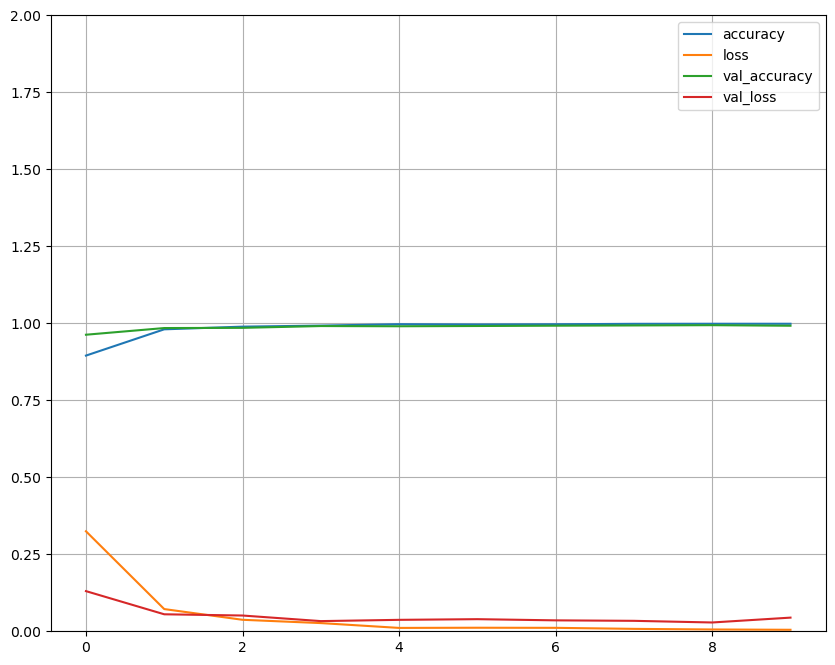

In [13]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,2)

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


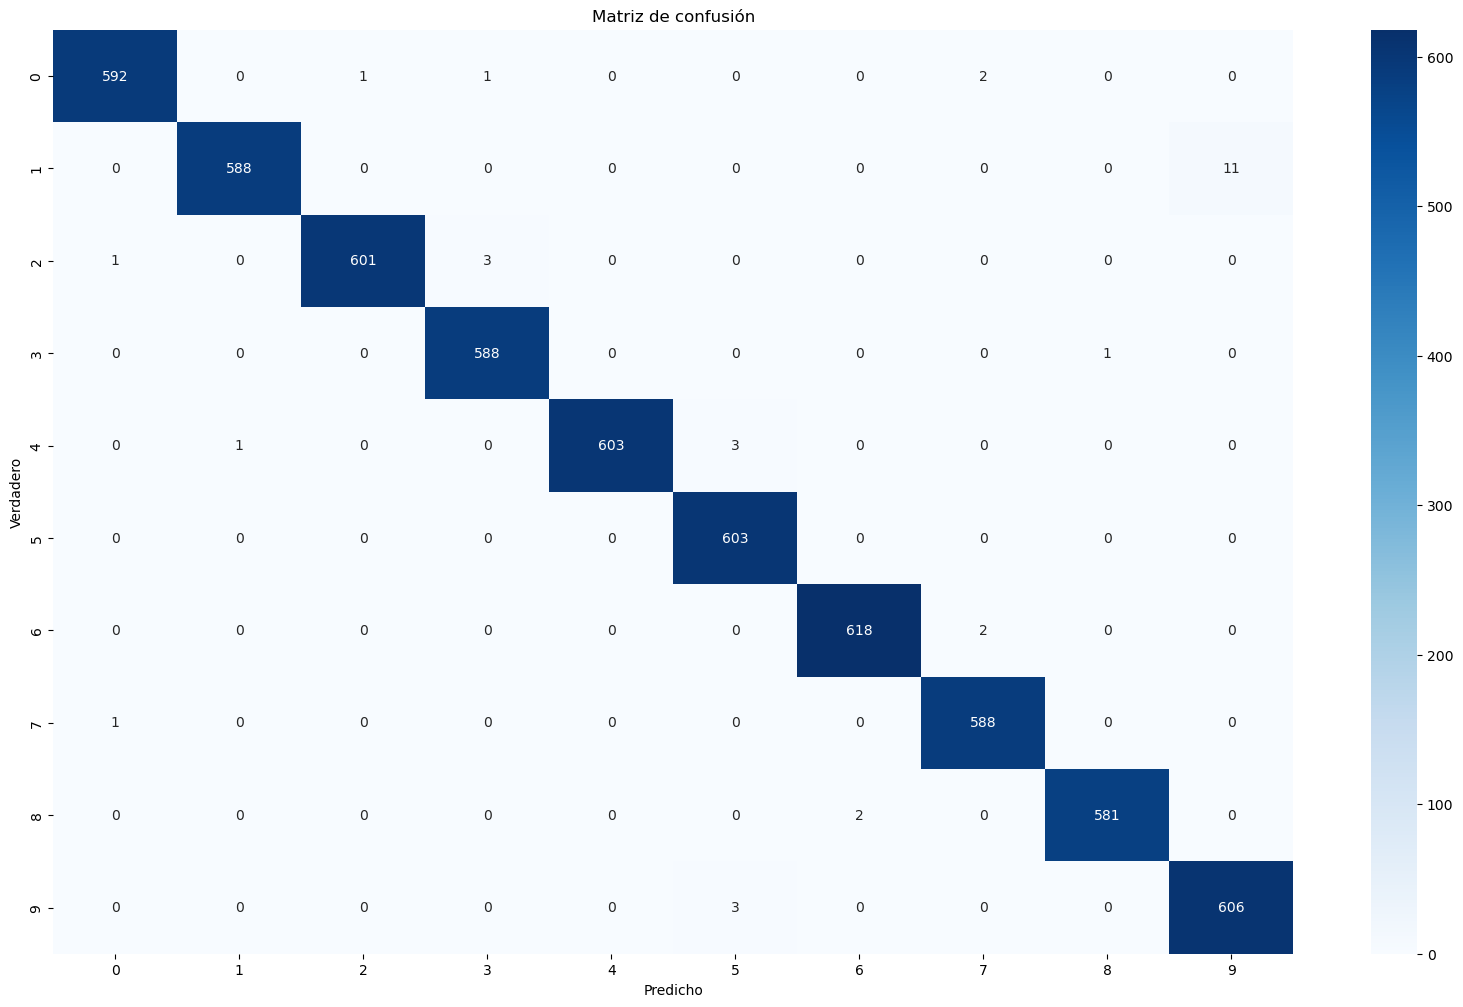

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_pred = model.predict(x_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
cm = confusion_matrix(y_test, y_test_pred_labels)

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.title('Matriz de confusión')
plt.show()